# Note: This Jupyter Notebook is build on top of
https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth

In [ ]:
#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15109 MiB, 15109 MiB


## Install Requirements

In [ ]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate==0.12.0 transformers ftfy bitsandbytes gradio

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 182 kB 7.6 MB/s 
     |████████████████████████████████| 18.7 MB 761 kB/s 
     |████████████████████████████████| 143 kB 7.1 MB/s 
     |████████████████████████████████| 5.5 MB 62.8 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 62.5 MB 1.2 MB/s 
     |████████████████████████████████| 11.6 MB 55.3 MB/s 
     |████████████████████████████████| 7.6 MB 54.1 MB/s 
     |████████████████████████████████| 106 kB 70.2 MB/s 
     |████████████████████████████████| 272 kB 47.2 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 55 kB 638 kB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 
     |████████████████████████████████| 213 kB 73.2 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |█████████

In [ ]:
#@title Login to HuggingFace 🤗

#@markdown You need to accept the model license before downloading or using the Stable Diffusion weights. Please, visit the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree. You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work.
from huggingface_hub import notebook_login
!git config --global credential.helper store
notebook_login()

Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


### Install xformers from precompiled wheel.

In [ ]:
%pip install -q https://github.com/metrolobo/xformers_wheels/releases/download/1d31a3ac_various_6/xformers-0.0.14.dev0-cp37-cp37m-linux_x86_64.whl
# These were compiled on Tesla T4, should also work on P100, thanks to https://github.com/metrolobo

# If precompiled wheels don't work, install it with the following command. It will take around 40 minutes to compile.
# %pip install git+https://github.com/facebookresearch/xformers@1d31a3a#egg=xformers

     |████████████████████████████████| 102.9 MB 114 kB/s 


## Settings and run

In [ ]:
#@markdown If model weights should be saved directly in google drive (takes around 4-5 GB).
save_to_gdrive = True #@param {type:"boolean"}
if save_to_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

#@markdown Name/Path of the initial model.
MODEL_NAME = "runwayml/stable-diffusion-v1-5" #@param {type:"string"}

#@markdown Path for images of the concept for training.
INSTANCE_DIR = "/content/data/snow" #@param {type:"string"}
!mkdir -p $INSTANCE_DIR

#@markdown A general name for class like dog for dog images.
CLASS_NAME = "mountains" #@param {type:"string"}
CLASS_DIR = f"/content/data/{CLASS_NAME}"

#@markdown Enter the directory name to save model at.

OUTPUT_DIR = "stable_diffusion_weights/snow" #@param {type:"string"}
if save_to_gdrive:
    OUTPUT_DIR = "/content/drive/MyDrive/" + OUTPUT_DIR
else:
    OUTPUT_DIR = "/content/" + OUTPUT_DIR

print(f"[*] Weights will be saved at {OUTPUT_DIR}")

!mkdir -p $OUTPUT_DIR

#@markdown sks is a rare identifier, feel free to replace it.
print(f"[*] Regularization images will be saved to {CLASS_DIR}")

Mounted at /content/drive
[*] Weights will be saved at /content/drive/MyDrive/stable_diffusion_weights/snow
[*] Regularization images will be saved to /content/data/mountains


In [ ]:
#@markdown Upload your images by running this cell.

#@markdown OR

#@markdown You can use the file manager on the left panel to upload (drag and drop) to INSTANCE_DIR (it uploads faster)

import os
from google.colab import files
import shutil

uploaded = files.upload()
for filename in uploaded.keys():
    dst_path = os.path.join(INSTANCE_DIR, filename)
    shutil.move(filename, dst_path)

Saving Slide11.png to Slide11.png
Saving Slide10.png to Slide10.png
Saving Slide9.png to Slide9.png
Saving Slide8.png to Slide8.png
Saving Slide7.png to Slide7.png
Saving Slide6.png to Slide6.png
Saving Slide5.png to Slide5.png
Saving Slide4.png to Slide4.png
Saving Slide3.png to Slide3.png
Saving Slide2.png to Slide2.png
Saving Slide1.png to Slide1.png


# Start Training

Use the table below to choose the best flags based on your memory and speed requirements. Tested on Tesla T4 GPU.


| `fp16` | `train_batch_size` | `gradient_accumulation_steps` | `gradient_checkpointing` | `use_8bit_adam` | GB VRAM usage | Speed (it/s) |
| ---- | ------------------ | ----------------------------- | ----------------------- | --------------- | ---------- | ------------ |
| fp16 | 1                  | 1                             | TRUE                    | TRUE            | 9.92       | 0.93         |
| no   | 1                  | 1                             | TRUE                    | TRUE            | 10.08      | 0.42         |
| fp16 | 2                  | 1                             | TRUE                    | TRUE            | 10.4       | 0.66         |
| fp16 | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 1.14         |
| no   | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 0.49         |
| fp16 | 1                  | 2                             | TRUE                    | TRUE            | 11.56      | 1            |
| fp16 | 2                  | 1                             | FALSE                   | TRUE            | 13.67      | 0.82         |
| fp16 | 1                  | 2                             | FALSE                   | TRUE            | 13.7       | 0.83          |
| fp16 | 1                  | 1                             | TRUE                    | FALSE           | 15.79      | 0.77         |


Add `--gradient_checkpointing` flag for around 9.92 GB VRAM usage.

remove `--use_8bit_adam` flag for full precision. Requires 15.79 GB with `--gradient_checkpointing` else 17.8 GB.

In [ ]:
# !accelerate launch train_dreambooth.py \
#   --pretrained_model_name_or_path=$MODEL_NAME \
#   --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
#   --instance_data_dir=$INSTANCE_DIR \
#   --class_data_dir=$CLASS_DIR \
#   --output_dir=$OUTPUT_DIR \
#   --with_prior_preservation --prior_loss_weight=1.0 \
#   --instance_prompt="photo of lakshmikantha {CLASS_NAME}" \
#   --class_prompt="photo of a {CLASS_NAME}" \
#   --seed=1337 \
#   --resolution=512 \
#   --train_batch_size=1 \
#   --train_text_encoder \
#   --mixed_precision="fp16" \
#   --use_8bit_adam \
#   --gradient_accumulation_steps=1 \
#   --learning_rate=1e-6 \
#   --lr_scheduler="constant" \
#   --lr_warmup_steps=0 \
#   --num_class_images=50 \
#   --sample_batch_size=4 \
#   --max_train_steps=800

!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path="/content/drive/MyDrive/stable_diffusion_weights/kar/" \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="photo of snow {CLASS_NAME}" \
  --class_prompt="photo of a {CLASS_NAME}" \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=800


The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--num_cpu_threads_per_process` was set to `1` to improve out-of-box performance
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
Caching latents: 100% 50/50 [00:15<00:00,  3.17it/s]
Steps: 100% 800/800 [12:59<00:00,  1.04it/s, loss=0.266, lr=1e-6][*] Weights saved at /content/drive/MyDrive/stable_diffusion_weights/snow/800
Steps: 100% 800/800 [13:33<00:00,  1.02s/it, loss=0.266, lr=1e-6]


## Convert weights to ckpt to use in web UIs like AUTOMATIC1111.

In [ ]:
#@markdown Download script
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py

In [ ]:
#@markdown Run conversion.
ckpt_path = OUTPUT_DIR + "/model.ckpt"

half_arg = ""
#@markdown  Whether to convert to fp16, takes half the space (2GB), might loose some quality.
fp16 = False #@param {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion.py --model_path $OUTPUT_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

Reshaping encoder.mid.attn_1.q.weight for SD format
Reshaping encoder.mid.attn_1.k.weight for SD format
Reshaping encoder.mid.attn_1.v.weight for SD format
Reshaping encoder.mid.attn_1.proj_out.weight for SD format
Reshaping decoder.mid.attn_1.q.weight for SD format
Reshaping decoder.mid.attn_1.k.weight for SD format
Reshaping decoder.mid.attn_1.v.weight for SD format
Reshaping decoder.mid.attn_1.proj_out.weight for SD format
[*] Converted ckpt saved at /content/drive/MyDrive/stable_diffusion_weights/snow/model.ckpt


## Inference

In [ ]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

model_path = OUTPUT_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe = StableDiffusionPipeline.from_pretrained(model_path, scheduler=scheduler, safety_checker=True, torch_dtype=torch.float16).to("cuda")

g_cuda = None

In [ ]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 1337 #@param {type:"number"}
g_cuda.manual_seed(seed)

In [ ]:
#@title Speak the sentence

# print("Language is ", language)
!apt-get install portaudio19-dev python-all-dev python3-all-dev
!pip install SpeechRecognition
!pip install PyAudio

#
# https://github.com/snakers4/silero-models
#

!pip install -q omegaconf torchaudio pydub
!pip install colabutils

import os
from os.path import exists

import numpy as np
import ipywidgets as widgets
from scipy.io import wavfile
from IPython.display import Audio, display, clear_output
from torchaudio.functional import vad
import os
import torch
import warnings
import torchaudio
from typing import List
from itertools import groupby


import torch
import random
from glob import glob
from omegaconf import OmegaConf

import io
import base64
import tempfile
from typing import Optional
from pydub import AudioSegment
from google.colab import files
from google.colab import output
from IPython import display as _display

def read_audio(path: str,
               target_sr: int = 16000):

    wav, sr = torchaudio.load(path)

    if wav.size(0) > 1:
        wav = wav.mean(dim=0, keepdim=True)

    if sr != target_sr:
        transform = torchaudio.transforms.Resample(orig_freq=sr,
                                                   new_freq=target_sr)
        wav = transform(wav)
        sr = target_sr

    assert sr == target_sr
    return wav.squeeze(0)


def record_audio(seconds: int = 3,
                 normalize_db: float = 0.1):
    # Use Javascript to record audio.
    record_js_code = """
      const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
      const b2text = blob => new Promise(resolve => {
        const reader = new FileReader()
        reader.onloadend = e => resolve(e.srcElement.result)
        reader.readAsDataURL(blob)
      })
      var record = time => new Promise(async resolve => {
        stream = await navigator.mediaDevices.getUserMedia({ audio: true })
        recorder = new MediaRecorder(stream)
        chunks = []
        recorder.ondataavailable = e => chunks.push(e.data)
        recorder.start()
        await sleep(time)
        recorder.onstop = async ()=>{
          blob = new Blob(chunks)
          text = await b2text(blob)
          resolve(text)
        }
        recorder.stop()
      })
      """
    print('Starting recording for {} seconds...'.format(seconds))
    _display.display(_display.Javascript(record_js_code))
    audio_string = output.eval_js('record(%d)' % (seconds * 1000.0))
    print('Finished recording!')
    audio_bytes = base64.b64decode(audio_string.split(',')[1])
    return audio_bytes_to_np(audio_bytes,
                             normalize_db=normalize_db)


def audio_bytes_to_np(wav_data: bytes,
                      normalize_db: float = 0.1):
    # Parse and normalize the audio.
    audio = AudioSegment.from_file(io.BytesIO(wav_data))
    audio.remove_dc_offset()
    if normalize_db is not None:
        audio.normalize(headroom=normalize_db)
    # Save to tempfile and load with librosa.
    with tempfile.NamedTemporaryFile(suffix='.wav') as temp_wav_file:
        fname = temp_wav_file.name
        audio.export(fname, format='wav')
        wav = read_audio(fname)
    return wav


def upload_audio(normalize_db: Optional[float] = None):
    audio_files = files.upload()
    fnames = list(audio_files.keys())
    if len(fnames) == 0:
        return None
    return read_audio(fnames[0])

record_or_upload = "Record" #@param ["Record", "Upload (.mp3 or .wav)"]
record_seconds =   4#@param {type:"number", min:1, max:10, step:1}
sample_rate = 16000

def _apply_vad(audio, boot_time=0, trigger_level=9, **kwargs):
  print('\nVAD applied\n')
  vad_kwargs = dict(locals().copy(), **kwargs)
  vad_kwargs['sample_rate'] = sample_rate
  del vad_kwargs['kwargs'], vad_kwargs['audio']
  audio = vad(torch.flip(audio, ([0])), **vad_kwargs)
  return vad(torch.flip(audio, ([0])), **vad_kwargs)

def _recognize(audio):
  display(Audio(audio, rate=sample_rate, autoplay=True))
  # if use_VAD == "Yes":
  #   audio = _apply_vad(audio)
  wavfile.write('test.wav', sample_rate, (32767*audio).numpy().astype(np.int16))
  # transcription = wav_to_text()
  # print('\n\nTRANSCRIPTION:\n')
  # print(transcription)

def _record_audio(b):
  clear_output()
  audio = record_audio(record_seconds)
  wavfile.write('/content/recorded.wav', sample_rate, (32767*audio).numpy().astype(np.int16))
  _recognize(audio)

def _upload_audio(b):
  clear_output()
  audio = upload_audio()
  _recognize(audio)
  return audio

if record_or_upload == "Record":
  button = widgets.Button(description="Record Speech")
  button.on_click(_record_audio)
  display(button)
else:
  audio = _upload_audio("")

###############################


Starting recording for 4 seconds...


<IPython.core.display.Javascript object>

Finished recording!


  0%|          | 0/50 [00:00<?, ?it/s]

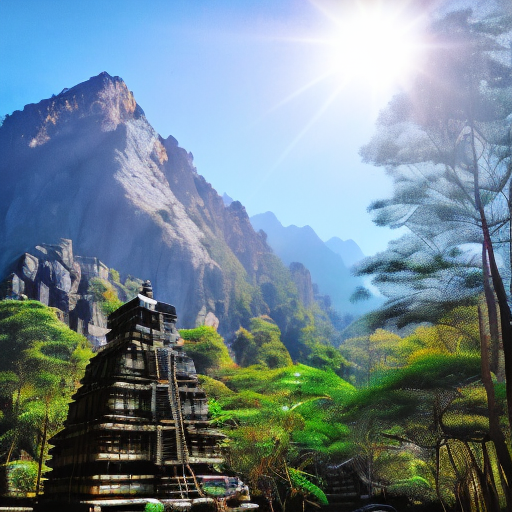

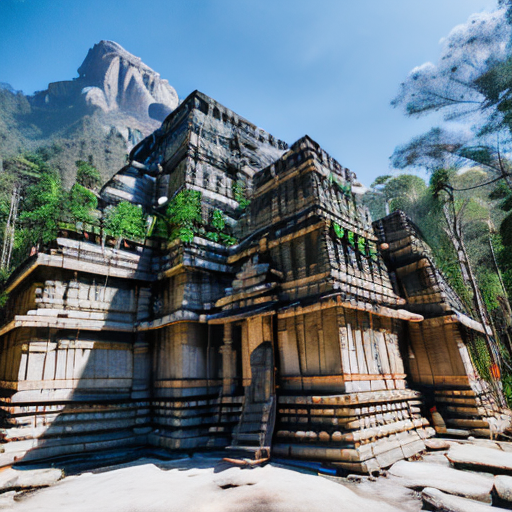

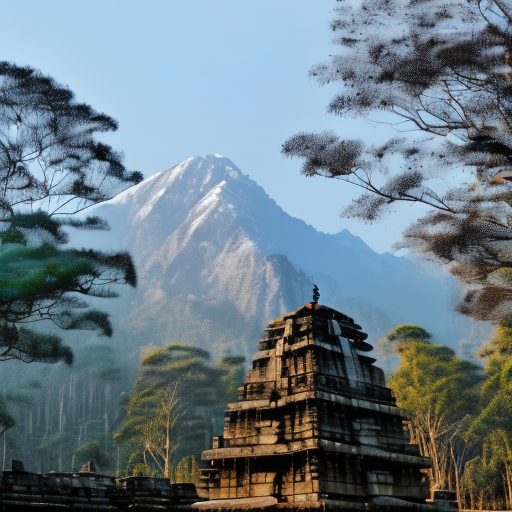

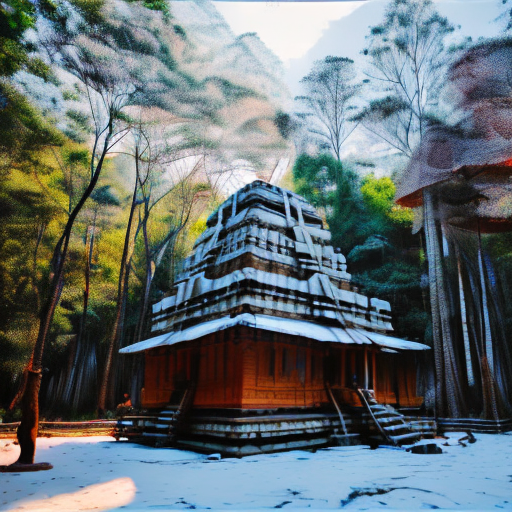

In [ ]:
#@title Run for generating images.

# !apt-get install portaudio19-dev python-all-dev python3-all-dev
# !pip install SpeechRecognition
# !pip install PyAudio

# import speech_recognition as sr

# r = sr.Recognizer()
# temp_voice = sr.AudioFile('/content/recorded.wav')
# with temp_voice as file:
#    audio = r.record(file)
#    try:
#         text = r.recognize_google(audio)
#         print("You said : {}".format(text))
#    except:
#         print("Sorry could not recognize what you said")
# textout=r.recognize_google(audio)
# prompt = textout

prompt = "photo of snow mountain with lakshmikantha temple in kar forest and sunlight" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
num_samples = 4 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 50 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)

In [ ]:
#@markdown Run Gradio UI for generating images.
import gradio as gr

def inference(prompt, negative_prompt, num_samples, height=512, width=512, num_inference_steps=50, guidance_scale=7.5):
    with torch.autocast("cuda"), torch.inference_mode():
        return pipe(
                prompt, height=int(height), width=int(width),
                negative_prompt=negative_prompt,
                num_images_per_prompt=int(num_samples),
                num_inference_steps=int(num_inference_steps), guidance_scale=guidance_scale,
                generator=g_cuda
            ).images

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            prompt = gr.Textbox(label="Prompt", value="photo of sks guy, digital painting")
            negative_prompt = gr.Textbox(label="Negative Prompt", value="")
            run = gr.Button(value="Generate")
            with gr.Row():
                num_samples = gr.Number(label="Number of Samples", value=4)
                guidance_scale = gr.Number(label="Guidance Scale", value=7.5)
            with gr.Row():
                height = gr.Number(label="Height", value=512)
                width = gr.Number(label="Width", value=512)
            num_inference_steps = gr.Slider(label="Steps", value=50)
        with gr.Column():
            gallery = gr.Gallery()

    run.click(inference, inputs=[prompt, negative_prompt, num_samples, height, width, num_inference_steps, guidance_scale], outputs=gallery)

demo.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().

Using Embedded Colab Mode (NEW). If you have issues, please use share=True and file an issue at https://github.com/gradio-app/gradio/
Note: opening the browser inspector may crash Embedded Colab Mode.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7fb93578f950>, 'http://127.0.0.1:7860/', None)

In [ ]:
#@title (Optional) Delete diffuser weights and only keep the ckpt to free up drive space (4GB).

#@markdown [ ! ] Caution, Only execute if you are sure u want to delete the diffuser format weights and only use the ckpt.
import shutil
from glob import glob
for f in glob(OUTPUT_DIR+"/*"):
    if not f.endswith(".ckpt"):
        try:
            shutil.rmtree(f)
        except NotADirectoryError:
            continue
        print("Deleted", f)